In [152]:
import pandas as pd
import numpy as np

X = pd.read_pickle(f"../input.pkl")
y = pd.read_pickle(f"../output.pkl")

In [153]:
X.shape

(763, 34)

In [154]:
import torch.cuda
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


True
NVIDIA GeForce RTX 4070 SUPER


In [155]:
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import root_mean_squared_error,r2_score

from sklearn.pipeline import Pipeline
from tabpfn import TabPFNClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(y.value_counts())

scalar=StandardScaler()
X_train_pr=scalar.fit_transform(X_train)
X_test_pr=scalar.transform(X_test)

X_trainp = pd.DataFrame(X_train_pr, columns=X_train.columns, index=X_train.index)
X_testp = pd.DataFrame(X_test_pr, columns=X_test.columns, index=X_test.index)


    # 모델 정의
preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), ['hb1ac','age', 'educ', 'house', 'pov', 'wt', 'ht', 'bmi', 'wst', 'hip', 'dia', 'pulse', 'sys', 'alt', 'albumin', 'ast', 'crea', 'chol', 'tyg', 'ggt', 'wbc', 'hb', 'hct', 'ldl', 'hdl', 'acratio', 'glu', 'insulin', 'crp', 'mvpa', 'ac_week']
),
            ("cat", OneHotEncoder(handle_unknown="ignore"), ['gender','marry','race'])
        ]
    )
# ['hb1ac','age', 'educ', 'house', 'pov', 'wt', 'ht', 'bmi', 'wst', 'hip', 'dia', 'pulse', 'sys', 'alt', 'albumin', 'ast', 'crea', 'chol', 'tyg', 'ggt', 'wbc', 'hb', 'hct', 'ldl', 'hdl', 'acratio', 'glu', 'insulin', 'crp', 'mvpa', 'ac_week']
#['age','gender','glu','hb1ac']
    # ============================================
    # 3. TabPFN v2 모델 정의
    # ============================================
model = TabPFNClassifier(
        device="auto",  # GPU 사용 가능 시 "cuda"
    )

    # ============================================
    # 4. Pipeline 구성
    # ============================================
pipe = Pipeline([
        ("preprocess", preprocess),
        ("tabpfn", model)
    ])

    # ============================================
    # 5. 모델 학습
    # ============================================
pipe.fit(X_trainp, y_train)


# 테스트셋 예측 및 평가
y_pred = pipe.predict(X_testp)    #이거 하면 [0.3,0.6,0.1]와 같이 prob 결과를 산출한 후 가장 값이 큰 인덱스를 y_pred에 넣는다. 
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred,average='weighted')
rec=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred,average='weighted')

r2=r2_score(y_test,y_pred)
rmse=root_mean_squared_error(y_test,y_pred)

print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 score: {f1:.4f}")
#print(f"r2:{r2}, rmse:{rmse}")

dbs
0.0    701
2.0     44
1.0     18
Name: count, dtype: int64


c:\Users\cmc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9542, Precision: 0.9479, Recall: 0.9542, F1 score: 0.9511


c:\Users\cmc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [156]:
y_test.dtypes

dbs    float64
dtype: object

c:\Users\cmc\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


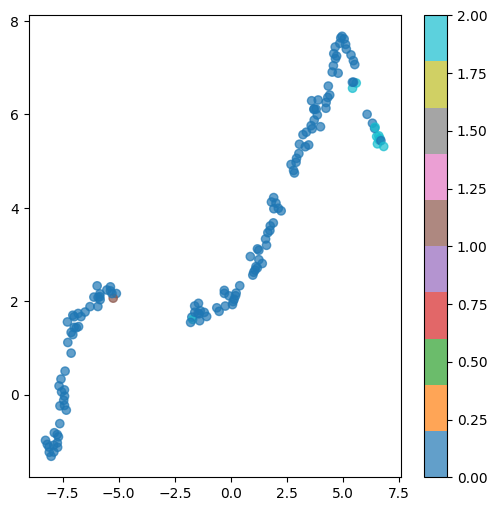

In [160]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

outputs=pipe.predict_proba(X_testp).astype(np.float32)
labels = y_test.astype(float).to_numpy()

reducer = umap.UMAP(n_components=2, random_state=42,n_neighbors=50)
X_umap = reducer.fit_transform(outputs)

# 시각화 (예: UMAP)
plt.figure(figsize=(6,6))
plt.scatter(X_umap[:,0], X_umap[:,1],c=labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.show()